# Sleep EMA CatBoost with Cross Validation

Replication Data for Wu et al. (2020) "Multi-Modal Data Collection for Measuring Health, Behavior, and Living Environment of Large-Scale Participant Cohorts: Conceptual Framework and Findings from Deployments": Ecological Momentary Assessment Data (Beiwe)

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, cross_validate

In [2]:
from catboost import CatBoostRegressor, Pool
import shap

shap.initjs()

In [3]:
if "jms_style_sheet" in plt.style.available:
    plt.style.use("jms_style_sheet")

In [4]:
df = pd.read_csv("data/UT1000_ema_wide.csv").dropna().reset_index(drop=True)
display(df.head()); df.shape

,pid,survey.date,content,energy,lonely,refreshed,restful,sad,sleep,stress
0,1193rv5x,2019-02-14,3.0,3.0,2.0,2.0,3.0,1.0,5.0,1.0
1,1193rv5x,2019-02-15,2.0,3.0,3.0,1.0,2.0,2.0,6.0,1.0
2,1193rv5x,2019-02-16,1.0,2.0,3.0,1.0,2.0,2.0,9.0,1.0
3,1193rv5x,2019-02-17,1.0,1.0,3.0,2.0,2.0,3.0,9.0,2.0
4,1193rv5x,2019-02-18,3.0,3.0,1.0,1.0,2.0,1.0,5.0,1.0


(17705, 10)

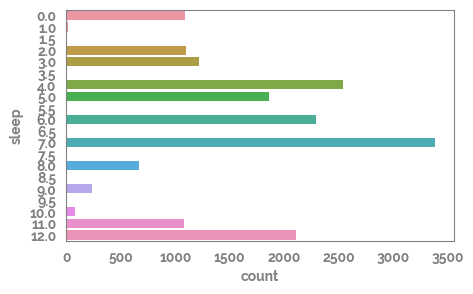

In [5]:
target="sleep"
feature_list=df.select_dtypes(float).drop(target, axis=1).columns.tolist()
_ = plt.figure(figsize=(5,3))
_ = sns.countplot(y=df[target])

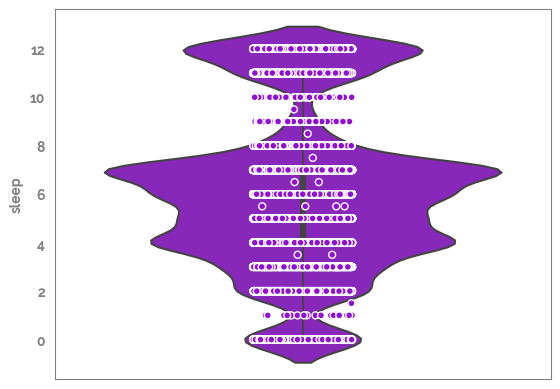

In [6]:
_ = sns.violinplot(y=df[target])
_ = sns.stripplot(y=df[target], edgecolor="white", linewidth=1)

In [7]:
train_idx = df.sample(frac=0.8, random_state=42).index.tolist()
test_idx = df.drop(train_idx, axis=0).index.tolist()

X=df[feature_list].astype(int).astype("category")
y=df[target]

X_train = df.loc[train_idx, feature_list].astype(int).astype("category")
y_train = df.loc[train_idx, target].astype(int)

X_test = df.loc[test_idx, feature_list].astype(int).astype("category")
y_test = df.loc[test_idx, target].astype(int)

In [8]:
model = CatBoostRegressor(iterations=500,
                               depth=None,
                               learning_rate=1,
                               loss_function='RMSE',
                               verbose=False)

# train the model
_ = model.fit(X_train, y_train, cat_features=feature_list)

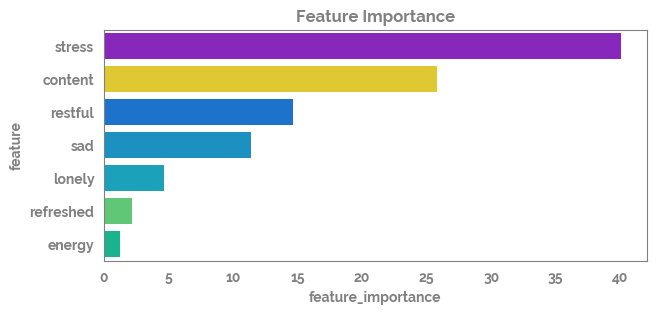

In [9]:
# create dataframe with importances per feature
feature_importance = pd.Series(dict(zip(feature_list, model.feature_importances_.round(2)))) 

feature_importance_df = pd.DataFrame(feature_importance.sort_values(ascending=False)).reset_index().rename(columns={"index": "feature", 0: "feature_importance"})

_ = plt.figure(figsize=(7, 3))
gini_plot = sns.barplot(data=feature_importance_df, 
                        x="feature_importance", 
                        y="feature")
_ = plt.title(f'Feature Importance')

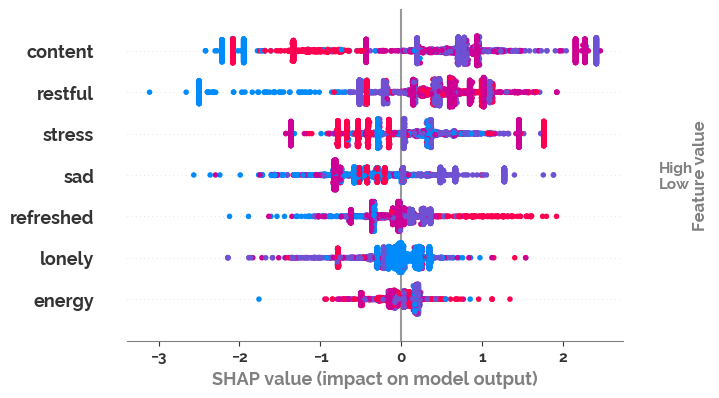

In [10]:
shap_values = model.get_feature_importance(Pool(X_test, label=y_test, cat_features=feature_list), type="ShapValues")

shap_values = shap_values[:,:-1]

_ = shap.summary_plot(shap_values, 
                                X_test.astype(int), 
                                feature_names=X_test.columns, 
                                max_display=X_test.shape[1],
                                show=True) 

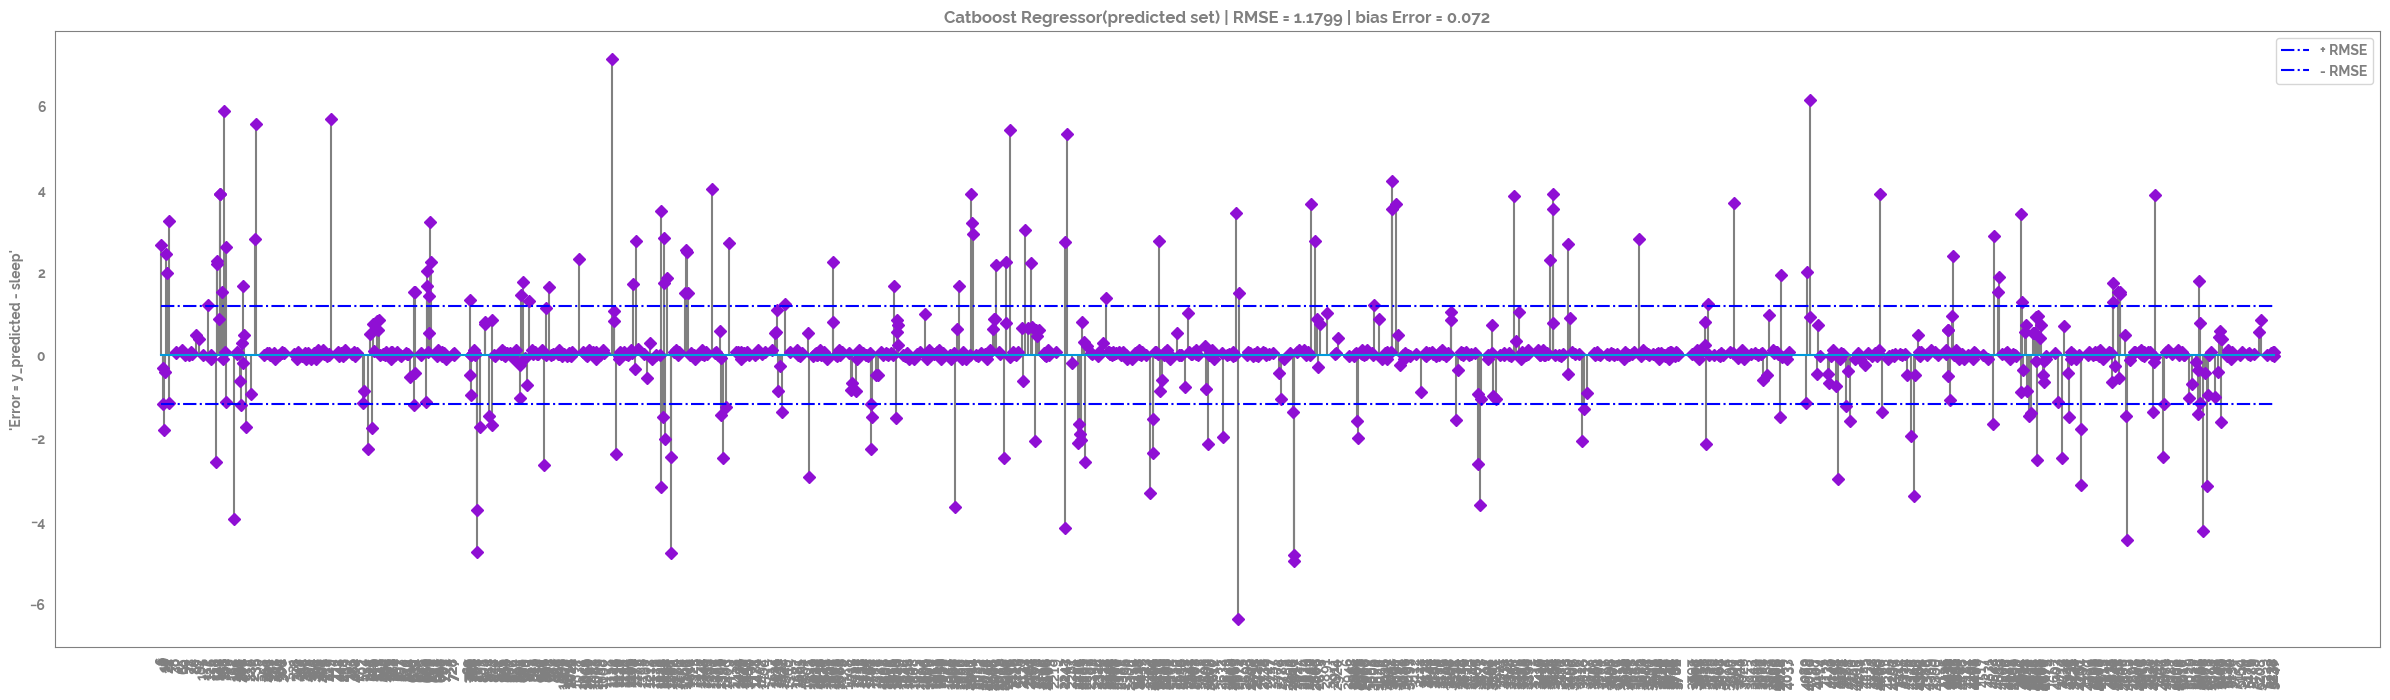

In [11]:
y_pred = model.predict(X_test)

df_test = pd.DataFrame({"y_pred": y_pred, target: y_test}).head(1000)

user_ids_first = df_test.head(1).index.tolist()[0]
user_ids_last = df_test.tail(1).index.tolist()[0]

_ = plt.figure(figsize=(30,8))
_ = plt.title(f"Catboost Regressor(predicted set) | RMSE = {round(np.sqrt(mean_squared_error(df_test['y_pred'], df_test[target])),4)} | bias Error = {round(np.mean(df_test['y_pred'] - df_test[target]), 4)}")
rmse_plot = plt.stem(df_test.index, df_test['y_pred'] - df_test[target], use_line_collection=True, linefmt='grey', markerfmt='D')
_ = plt.hlines(y=round(np.sqrt(mean_squared_error(df_test['y_pred'], df_test[target])),2), colors='b', linestyles='-.', label='+ RMSE', 
                xmin = user_ids_first, 
                xmax = user_ids_last
                ) 
_ = plt.hlines(y=round(-np.sqrt(mean_squared_error(df_test['y_pred'], df_test[target])),2), colors='b', linestyles='-.', label='- RMSE', 
                xmin = user_ids_first, 
                xmax = user_ids_last
                ) 
_ = plt.xticks(rotation=90, ticks=df_test.index)
_ = plt.ylabel(f"'Error = y_predicted - {target}'")
_ = plt.legend()

In [12]:
accuracies_list = list()
all_pred_test_df = pd.DataFrame()
all_cors_df = pd.DataFrame()
kfold = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)
fold_number = 1

model = CatBoostRegressor(iterations=500,
                               depth=None,
                               learning_rate=1,
                               loss_function='RMSE',
                               verbose=False)

# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X):
    # select rows
    train_X, test_X = X.loc[train_ix, :], X.loc[test_ix, :]
    train_y, test_y = y.loc[train_ix], y.loc[test_ix]
    # summarize train and test composition
    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
    
    _ = model.fit(X = train_X, 
                y = train_y,
               cat_features=X.columns.tolist())
    
    pred_y = model.predict(test_X)
    _ = accuracies_list.append(np.sqrt(mean_squared_error(test_y, pred_y)))
    
    pred_test_df = pd.DataFrame({target: test_y,
                 "predict": pred_y,
                                "fold_number": f"fold_{fold_number}"})
    
    all_pred_test_df = pd.concat([all_pred_test_df, 
                             pred_test_df
                            ])
    fold_number += 1

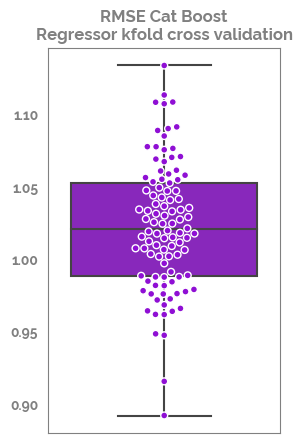

In [13]:
_ = plt.figure(figsize=(3,5))
_ = sns.boxplot(y = accuracies_list)
_ = sns.swarmplot(y = accuracies_list, edgecolor="white", linewidth=1)
_ = plt.title("RMSE Cat Boost\nRegressor kfold cross validation")

In [14]:
pd.DataFrame(accuracies_list).describe().T

,count,mean,std,min,25%,50%,75%,max
0,100.0,1.022321,0.043976,0.891743,0.987997,1.020195,1.052509,1.133438
